# Scrape some text from Wikipedia

In [2]:
# ! pip install wikipedia

import wikipedia
import re

def wiki_download(name):
    wiki = wikipedia.page(name)
    text = wiki.content
    text = re.sub(r'==.*?==+', '', text)
    text = text.replace('\n\n\n', '\n')
    return text
    
text = wiki_download('Abraham Lincoln')
text_split = text.strip().split()

# Generate some images

309 46.5
309 86.53125
309 93.171875
309 138.265625
309 186.375
309 204.203125
309 232.46875
309 243.09375
309 269.59375
309 287.421875
309 319.53125
309 46.5
309 86.53125
309 93.171875
309 138.265625
309 186.375
309 204.203125
309 232.46875
309 243.09375
309 269.59375
309 287.421875
309 319.53125
309 46.5
309 86.53125
309 93.171875
309 138.265625
309 186.375
309 204.203125
309 232.46875
309 243.09375
309 269.59375
309 287.421875
309 319.53125
309 46.5
309 86.53125
309 93.171875
309 138.265625
309 186.375
309 204.203125
309 232.46875
309 243.09375
309 269.59375
309 287.421875
309 319.53125
309 46.5
309 86.53125
309 93.171875
309 138.265625
309 186.375
309 204.203125
309 232.46875
309 243.09375
309 269.59375
309 287.421875
309 319.53125
309 46.5
309 86.53125
309 93.171875
309 138.265625
309 186.375
309 204.203125
309 232.46875
309 243.09375
309 269.59375
309 287.421875
309 319.53125
309 46.5
309 86.53125
309 93.171875
309 138.265625
309 186.375
309 204.203125
309 232.46875
309 243.09375


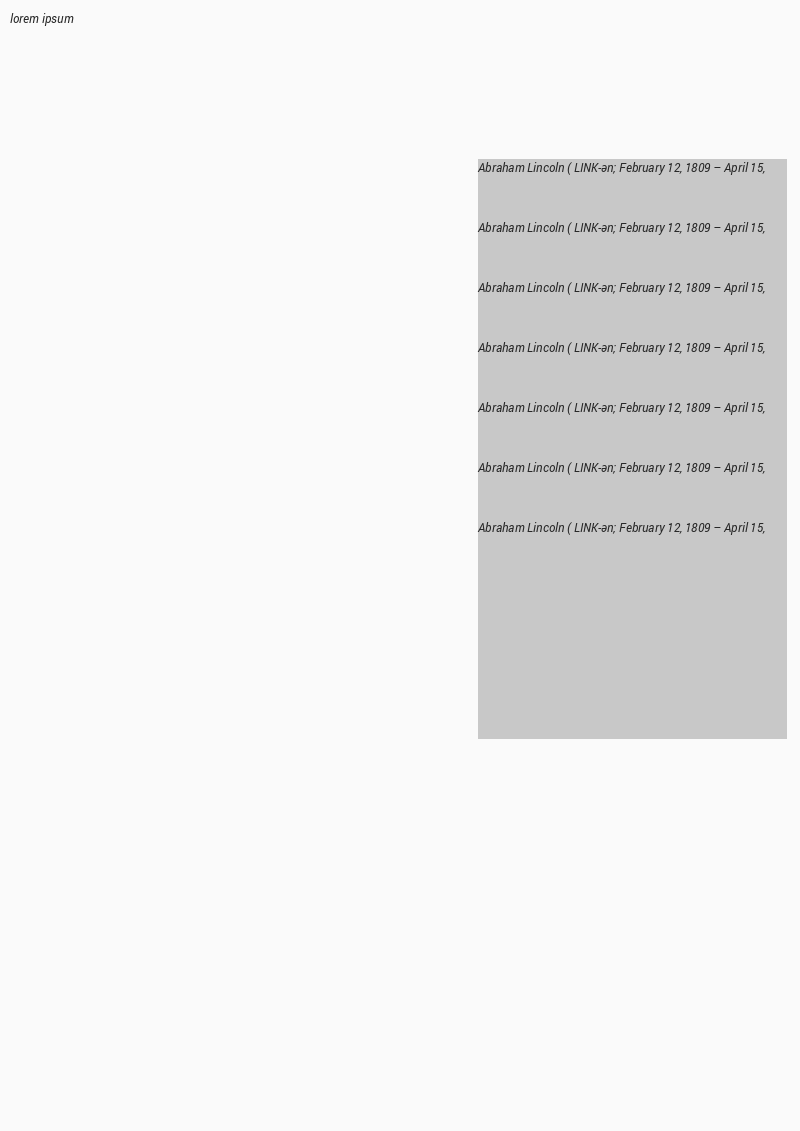

In [24]:
from PIL import Image, ImageDraw, ImageFont
import math
import random
from typing import Union, Tuple

class GenerateImage:
    def __init__(self, text_split, width = 800, ratio = 2 ** 0.5) -> None:
        self.text_split = text_split
        self.text_idx = 0
        self.width = width
        self.height = int(width * ratio)
        self.image = Image.new('RGB', size=(width, self.height), color=(250,250,250))  # A4
        self.draw = ImageDraw.Draw(self.image)
        self.font = ImageFont.truetype('fonts/Roboto-Italic', 12)
        self.blocks = []

    def get_block_coordinates(self):
        block_width_fraction = 0.3 + random.random() * 0.4
        block_width = int(self.width * block_width_fraction)

        block_height_fraction = 0.2 + random.random() * 0.4
        block_height = int(self.height * block_height_fraction)

        remaining_width = self.width - block_width
        remaining_height = self.height - block_height

        x_pos = random.randint(0, remaining_width)
        y_pos = random.randint(0, remaining_height)
        
        return [(x_pos, y_pos), (x_pos+block_width, y_pos+block_height)]
    
    def print_line(self, origin: Tuple[int, int], 
                   box_width: int, remaining_height: int) -> Union[int, None]:
        """_summary_
        Args:
            origin: x, y coordinates of top-left corner of the line
            remaining_width: width of line for typesetting words in pixels
            remaining_height: remaining pixels in the bounding box
                do not draw any text if the line height exceeds remaining_height
        Returns:
            height of the drawn line, None if drawing the line was not possible
        """
        end_idx = self.text_idx
        success_end_idx, success_height = None, None
        for end_idx in range(self.text_idx + 1, len(self.text_split) + 1):
            sub_text = ' '.join(self.text_split[self.text_idx: end_idx])
            text_width = self.draw.textlength(sub_text, font=self.font)
            print(box_width, text_width)
            text_height = 60
            if text_height > remaining_height:
                return None
            elif text_width > box_width:
                break
            else:
                success_height = text_height
                success_end_idx = end_idx
        if success_end_idx is None:
            return None
        else:
            sub_text = ' '.join(self.text_split[self.text_idx: success_end_idx])
            x, y = origin
            self.draw.text(origin, sub_text, font=self.font, fill=(40,40,40))
            return text_height
            
    
    def print_text(self):
        coordinates = self.get_block_coordinates()
        self.draw.rectangle(coordinates, fill=(200, 200, 200))  # type: ignore
        (x0, y0), (x1, y1) = coordinates
        block_width = x1 - x0 + 1
        block_height = y1 - y0 + 1
        current_y = y0
        while True:
            current_line_height = self.print_line(origin=(x0, current_y), 
                                                  box_width=block_width,
                                                  remaining_height=block_height - current_y)
            if current_line_height is None:
                break
            else:
                current_y += current_line_height


g = GenerateImage(text_split)
g.print_text()
g.draw.text((10,10), 'lorem ipsum', font=g.font, fill=(40,40,40))
display(g.image)